# 实验环境
Python 3.10.6
PyTorch 1.13.0
Matplotlib 3.7.1

# 导入必要的库

In [26]:
import os

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision import models

import matplotlib.pyplot as plt

# 设置信息

In [27]:
device = (
    torch.device(device="cuda")
    if torch.cuda.is_available()
    else torch.device(device="cpu")
)
print("Device: {}".format(device))

config = {
    "data_path": os.path.join("dataset", "training"),
    "test_path": os.path.join("dataset", "test"),
    "weights_path": os.path.join("model_weights.pth"),
    "data_size": 3616,
    "HEIGHT": 224,
    "WIDTH": 224,
    "_R_MEAN": 123.68,
    "_G_MEAN": 116.78,
    "_B_MEAN": 103.94,
    "_R_STD": 1,
    "_G_STD": 1,
    "_B_STD": 1,
    "_RESIZE_SIDE_MIN": 256,
    "_RESIZE_SIDE_MAX": 512,
    "batch_size": 32,
    "num_class": 5,
    "epoch_size": 150,
    "loss_scale_num": 1024,
    "prefix": "resent-ai",
    "directory": "model_resnet",
    "save_checkpoint_steps": 10,
}

lr = 5e-4

Device: cuda


# 定义训练数据集和测试数据集并预处理

In [28]:
training_data = datasets.ImageFolder(
    root=config["data_path"],
    transform=transforms.Compose(
        transforms=[
            transforms.RandomResizedCrop(
                size=(config["HEIGHT"], config["WIDTH"]),
                scale=(0.5, 1.0),
                ratio=(1.0, 1.0),
            ),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
)


test_data = datasets.ImageFolder(
    root=config["test_path"],
    transform=transforms.Compose(
        transforms=[
            transforms.Resize(size=(config["_RESIZE_SIDE_MIN"])),
            transforms.CenterCrop(size=(config["HEIGHT"], config["WIDTH"])),
            transforms.ToTensor(),
        ]
    ),
)


training_loader = DataLoader(
    dataset=training_data,
    batch_size=config["batch_size"],
    shuffle=True,
    drop_last=True,
)


test_loader = DataLoader(
    dataset=test_data,
    batch_size=1,
)

# 打印部分信息

Training set size: 3670
Test set size: 5
Channel size, height, width: torch.Size([3, 224, 224])
Label of the first photo: 3


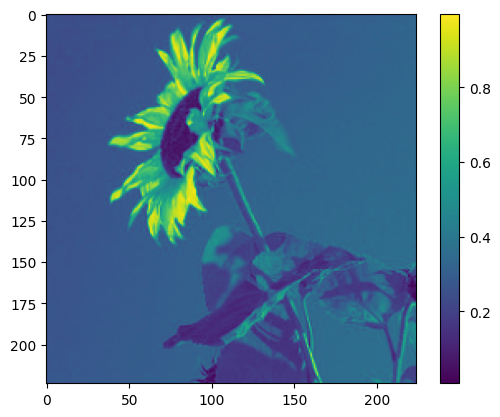

In [29]:
print("Training set size: {}".format(len(training_data)))
print("Test set size: {}".format(len(test_data)))

classes = test_data.classes
training_features, training_labels = next(iter(training_loader))
print("Channel size, height, width: {}".format(training_features[0].shape))
print("Label of the first photo: {}".format(training_labels[0]))

plt.figure()
plt.imshow(training_features[0, 0, ...])
plt.colorbar()
plt.grid(visible=False)
plt.show()

# 定义神经网络模型、损失函数和优化器

In [30]:
model = models.resnet50()
model.fc = nn.Linear(in_features=2048, out_features=5)
model.to(device=device)
model.load_state_dict(torch.load(f=config["weights_path"]))
model.eval()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    params=model.parameters(),
    lr=lr,
    momentum=0.9,
    weight_decay=1e-4,
)

# 训练神经网络模型并测试结果
由于已经预训练过模型的参数，这里将 epoch 设置为 1，仅训练 1 轮并打印对测试图像的分类结果。实验要求的三张测试图像路径分别为`./dataset/test/rose/rose.jpg`、`./dataset/test/sunflower/sunflower.jpg`、`./dataset/test/tuplis/tuplis.jpg`。由于 datasets.ImageFolder 类要求五个分类文件夹下都有数据样本，因此在其余两个分类的文件夹下分别随机放了一张测试图像。

In [31]:
def train_loop(dataloader, model, loss_fn, optimizer):
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)

            print("Class of y: {}".format(classes[y.item()]))
            print("Y: {}".format(y))
            print("Prediction: {}\n".format(pred))

            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print("Accuracy: {}, Avg loss: {}\n".format(correct, test_loss))


epoch = 1
for _ in range(epoch):
    print("Epoch {}".format(_))
    train_loop(
        dataloader=training_loader, model=model, loss_fn=loss_fn, optimizer=optimizer
    )
    test_loop(dataloader=test_loader, model=model, loss_fn=loss_fn)
    torch.save(obj=model.state_dict(), f=config["weights_path"])

Epoch 0
Class of y: daisy
Y: tensor([0], device='cuda:0')
Prediction: tensor([[ 8.4012, -0.0417, -5.9031, -2.9088,  0.5198]], device='cuda:0')

Class of y: dandelion
Y: tensor([1], device='cuda:0')
Prediction: tensor([[-0.9358,  7.6301, -3.3722, -1.8398, -1.2206]], device='cuda:0')

Class of y: roses
Y: tensor([2], device='cuda:0')
Prediction: tensor([[-2.9096, -4.0142,  5.7608, -5.3252,  6.5503]], device='cuda:0')

Class of y: sunflowers
Y: tensor([3], device='cuda:0')
Prediction: tensor([[-1.3705, -8.1540, -7.1145, 18.1573, -2.5277]], device='cuda:0')

Class of y: tulips
Y: tensor([4], device='cuda:0')
Prediction: tensor([[-5.0013, -8.2304,  2.3960, -4.4516, 15.5245]], device='cuda:0')

Accuracy: 0.8, Avg loss: 0.23298973306041262

